In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

## Concat. all preds

In [4]:
ids = []
masks = []
fold_df = pd.DataFrame(columns=['pid', 'Fold'])
for root, dir_, files in os.walk('/data/PAB_data/midline_data/'):
    if 'midline_finder_preds.npz' in files:
        tmp = pd.DataFrame(columns=['pid', 'Fold'])
        print(root)
        fold = root.split('/')[-1]
        data = np.load(os.path.join(root, 'midline_finder_preds.npz'))
        id_list = [''.join(elem) for elem in data['ids']]
        ids.extend(id_list)
        masks.extend(data['masks'])
        tmp['pid'] = id_list
        tmp['Fold'] = fold
        fold_df = fold_df.append(tmp)
display(fold_df.head())
all_data = {ids[i]: masks[i] for i in range(len(ids))}
print(len(list(all_data.keys())))

/data/PAB_data/midline_data/q4
/data/PAB_data/midline_data/q2
/data/PAB_data/midline_data/q3
/data/PAB_data/midline_data/q1


,pid,Fold
0,27_05_2014_96_Sag_IVC,q4
1,fr_608_LS_Sag,q4
2,23_05_2014_149_Sag_LS,q4
3,fr_615_TS_Sag,q4
4,27_05_2014_113_Sag,q4


375


## Post-processing for midline finder

In [5]:
from skimage import measure
from scipy import interpolate
from scipy.ndimage import gaussian_filter

In [6]:
preds = np.load('/data/PAB_data/midline_data/q1/midline_finder_preds.npz')
print(list(preds.keys()))
ids, masks= preds.values()
ids.shape, masks.shape

['ids', 'masks']


((100,), (100, 1, 512, 512))

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

### Plot predictions

In [8]:
@interact
def plot_mask(name=sorted(list(ids))):
    img = np.load(f'/data/PAB_data/midline_data/q1/slices/{name}.npy')
    fig, ax = plt.subplots(1,1, figsize=(9, 9))
    ax.axis('off')
    n = list(ids).index(name)
    mask = sigmoid(masks[n, 0])
    norm_mask = np.where(mask < 0.5, np.nan, 1.0)
    # 0: MIP, 1: MIDLINE, 2:STD
    ax.imshow(img, cmap='gray')
    ax.imshow(norm_mask, alpha=0.5, cmap='viridis')

interactive(children=(Dropdown(description='name', options=('01_06_2014_363_Sag', '01_06_2014_364_Sag', '01_06…

### Plot midline

In [9]:
def mask2midline(pred, N=20):
    # Get center of contours for line fitting
    x_template = np.zeros_like(pred)
    y_template = np.zeros_like(pred)
    for x in range(x_template.shape[0]):
        x_template[:, x] = x
        y_template[x] = x
    norm_pred = np.where(pred < 0.5, 0, 1.0) # Binarise mask
    exp_x = x_template*norm_pred
    
    x_list = []
    y_list = []
    # Calculate expectation
    for i in range(pred.shape[0]):
        y_preds = np.mean(exp_x[i]).astype(int)
        if y_preds != 0:
            x_list.append(np.mean(exp_x[i][exp_x[i] != 0]))
            y_list.append(i)
    # Sample list at even intervals
    samp_y = []
    samp_x = []
    for n in range(N):
        int_ = len(y_list) // N
        samp_y.append(y_list[n*int_])
        samp_x.append(x_list[n*int_])
    # Fit spline
    tck = interpolate.splrep(samp_y, samp_x, k=1, s=0)
    xd = np.linspace(min(samp_y), max(samp_y), 512)
    fit = interpolate.splev(xd, tck, der=0)
    
    return samp_y, samp_x, fit, xd

In [10]:
@interact
def plot_midline(name=sorted(list(all_data.keys()))):
    img = np.load(f'/data/PAB_data/images_coronal/all_projections/{name}.npy')
    img = img[..., 0]
    pred = all_data[name][0]
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))    
    
    y, x, fit, xd = mask2midline(pred, N=15)
    
    # ---- Plotting ----
    norm_pred = np.where(pred < 0.5, 0, 1) 
    ax[0].set_title('Pred')
    ax[0].imshow(img, cmap='gray')
    ax[0].imshow(np.where(pred < 0.5, np.nan, 1), alpha=0.5)
    ax[0].scatter(x, y, c='y', marker='o', alpha=1, s=40, edgecolor='k')
    
    ax[1].set_title('Pred Midline')
    ax[1].imshow(img, cmap='gray')
    ax[1].plot(fit, xd, c='y', lw=3)
    ax[1].imshow(np.where(norm_pred==0, np.nan, 1), alpha=0.5)
    ax[1].scatter(x, y, c='y', marker='o', s=40, edgecolor='k')
    
    ax[1].set_ylim([511, 0])
    ax[1].set_xlim([0, 511])

interactive(children=(Dropdown(description='name', options=('01_06_2014_363_Sag', '01_06_2014_364_Sag', '01_06…

### Evaluate predictions 

In [11]:
def min_distance(x, y, fit):
    # Iterate over all predicted points
    dist_dict = {}
    point_dict = {}
    for point in zip(x, y):
        dist = []
        # Iterate over all points in fit 
        for y_fit, x_fit in enumerate(fit):
            x_dist, y_dist = (point[0] - x_fit)**2, (point[1] - y_fit)**2
            dist.append(np.sqrt(x_dist + y_dist)*1.25) # x 1.25 to get in mm instead of pixels
        dist_dict[point] = min(dist)
        point_dict[point] = (fit[np.argmin(dist)], np.argmin(dist))
        #break
    return dist_dict, point_dict

In [12]:
@interact
def evaluate_predictions(name=sorted(list(all_data.keys()))):
    img = np.load(f'/data/PAB_data/images_coronal/all_projections/{name}.npy')
    print(img.shape)
    img = img[..., 0]
    fold = fold_df[fold_df['pid'] == name]['Fold'].values[0]
    gt_coords = pd.read_csv(f'/data/PAB_data/midline_data/{fold}/coordinates/{name}.csv')
    pred = all_data[name][0]
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # --- Format gt ---
    x_gt, y_gt = gt_coords['X'].to_list(), gt_coords['Y'].to_list()
    # Fit spline
    tck = interpolate.splrep(y_gt, x_gt, k=1, s=0)
    fit_x = np.linspace(int(min(y_gt)), int(max(y_gt)), int(max(y_gt)-min(y_gt)))
    fit = interpolate.splev(fit_x, tck, der=0)
    # Extend vertically either end
    top = [fit[0]]*int(min(y_gt))
    bot = [fit[-1]]*(512-int(max(y_gt)))
    top.extend(fit)
    top.extend(bot)
    if len(top) != 512:
        top.append(fit[-1])
    
    # --- Evaluate ---- 
    # Minimum Euclidean distance between detected points 
    # and piecewise linear curve through manual annotations.
    y, x, pred_fit, pred_xd = mask2midline(pred, N=15)
    
    dist_dict, point_dict = min_distance(x, y, top)
    xd = np.linspace(0, 512, 512)
    # ---- Plotting ----
    norm_pred = np.where(pred < 0.5, 0, 1) 
#     ax[0].set_title('GT')
#     ax[0].imshow(img, cmap='gray')
#     ax[0].plot(top,xd , c='y', lw=3, alpha=1)
#     ax[0].scatter(x_gt, y_gt, marker='o', c='y', s=40, edgecolor='k')
    
    
    ax.set_title('Pred')
    ax.imshow(img, cmap='gray')
    ax.plot(top, xd , c='y', lw=1.5, alpha=1)
    #ax[1].imshow(np.where(norm_pred==0, np.nan, 1), alpha=0.5, cmap='autumn')
    ax.scatter(x, y, marker='o', c='b', s=40, alpha=0.7)
    # Plot contours
    for key, val in point_dict.items():
        xs, ys = [key[0], val[0]], [key[1], val[1]]
        ax.plot(xs, ys, c='r', ls ='-', lw=2, marker=None)
        
        
    ax.set_ylim([511, 0])
    ax.set_xlim([0, 511])
#     ax[1].set_ylim([512, 0])
#     ax[1].set_xlim([0, 512])

interactive(children=(Dropdown(description='name', options=('01_06_2014_363_Sag', '01_06_2014_364_Sag', '01_06…

### Collect distances

In [13]:
def collect_dist(name, fold, mask):
    gt_coords = pd.read_csv(f'/data/PAB_data/midline_data/{fold}/coordinates/{name}.csv')
    pred = mask[0]
    # --- Format gt ---
    x_gt, y_gt = gt_coords['X'].to_list(), gt_coords['Y'].to_list()
    # Fit spline
    tck = interpolate.splrep(y_gt, x_gt, k=1, s=0)
    fit_x = np.linspace(int(min(y_gt)), int(max(y_gt)), int(max(y_gt)-min(y_gt)))
    fit = interpolate.splev(fit_x, tck, der=0)
    # Extend vertically either end
    top = [fit[0]]*int(min(y_gt))
    bot = [fit[-1]]*(512-int(max(y_gt)))
    top.extend(fit)
    top.extend(bot)
    if len(top) != 512:
        top.append(fit[-1])
    
     # --- Fitting ---
    y, x, pred_fit, pred_xd  = mask2midline(pred, N=15)
    
    # --- Evaluate ---- 
    dist_dict, point_dict = min_distance(x, y, top)
    distances = list(dist_dict.values())
    
    return np.mean(distances), np.max(distances)

In [14]:
dist_dict = {}
for name in pd.unique(fold_df['pid']):
    fold = fold_df[fold_df['pid'] == name]['Fold'].values
    mean, max_ = collect_dist(name, *fold, all_data[name])
    dist_dict[name] = {'Mean': mean, 'Max': max_}
dist_df = pd.DataFrame(dist_dict)
display(dist_df.T.head())

,Mean,Max
27_05_2014_96_Sag_IVC,1.447657,2.315746
fr_608_LS_Sag,0.732591,2.343122
23_05_2014_149_Sag_LS,0.965025,1.865310
fr_615_TS_Sag,0.674445,1.820039
27_05_2014_113_Sag,1.244107,2.657813


In [15]:
dist_df.T.sort_values(by='Max', ascending=False).head()

,Mean,Max
04_06_2014_414_LS_Sag,25.475030,26.213681
27_05_2014_96_Sag,16.662598,17.867065
24_05_2014_133_Sag_TS,3.182013,15.802604
22_05_2014_175_Sag,12.782451,14.202274
28_05_2014_79_Sag_TS,1.573787,8.361521


In [16]:
dist_df.T.iloc[dist_df.T['Max'].argmax()]

Mean    25.475030
Max     26.213681
Name: 04_06_2014_414_LS_Sag, dtype: float64

Percentage with max/mean error $\leq 5 mm$: 

In [17]:
dist_df.T[dist_df.T <= 5].count()/len(dist_df.T.index) * 100

Mean    99.2
Max     96.0
dtype: float64

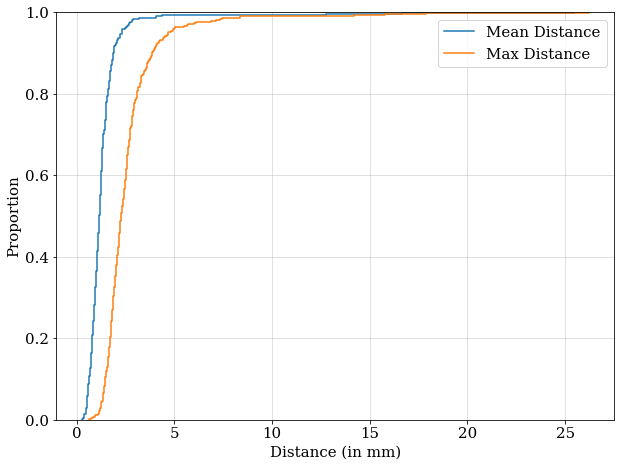

In [18]:
fig= plt.figure(figsize=(10, 7.5))
g = sns.ecdfplot(data=dist_df.T, x='Mean', label='Mean')
g = sns.ecdfplot(data=dist_df.T, x='Max', label='Max')

g.set_xlabel('Distance (in mm)')
g.grid(which='major', alpha=0.5)
new_labels = ['Mean Distance', 'Max Distance']
for t, l in zip(g.legend().texts, new_labels): t.set_text(l)

# Extract Sagittal Midline

In [19]:
from ast import literal_eval
import SimpleITK as sitk

In [20]:
direct_df = pd.read_csv('../dicom_direction.csv', index_col='Name', converters={'Direction': literal_eval})
base_direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
direct_df.head()

,Direction,Origin
Name,,
03_06_2014_389_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(201.6633148, -353.9631348, 131.249939)"
03_06_2014_402_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(173.4781189, -159.1593781, 98.0)"
03_06_2014_396_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(203.453125, -223.1618958, 57.64001465)"
03_06_2014_395_Sag,"(-0.3499322470372717, 0.0, -0.9367750116668602...","(190.7415924, -124.9147186, 81.60995483)"
03_06_2014_399_TS_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(165.7218781, -164.1593781, 122.75)"


In [21]:
def pad_image(img, output_shape=(512, 512, 512)):
    """
    Insert into array of fixed size - such that all inputs to model have same dimensions
    """
    padding = [(s-x)//2.0 for x, s in zip(output_shape, img.GetSize())]
    output_origin = img.TransformContinuousIndexToPhysicalPoint(padding)
    pad = sitk.ResampleImageFilter()
    pad.SetInterpolator(sitk.sitkLinear)
    pad.SetDefaultPixelValue(-1024)
    pad.SetOutputSpacing(img.GetSpacing())
    pad.SetSize(output_shape)
    pad.SetOutputOrigin(output_origin)
    pad.SetOutputDirection(img.GetDirection())
    return pad.Execute(img), padding

def resample(image, new_spacing):
    """
    Resample image to new resolution with pixel dims defined by new_spacing
    """
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetOutputSpacing(new_spacing)
    orig_size = np.array(image.GetSize(), dtype=np.int)
    orig_spacing = image.GetSpacing()
    ratio = [x/y for x, y in zip(orig_spacing, new_spacing)]
    new_size = orig_size*ratio
    new_size = np.ceil(new_size).astype(np.int)
    new_size = [int(s) for s in new_size]
    resample.SetSize(new_size)
    return resample.Execute(image), ratio

def normalize(img, min=0, max=255):
    """
    Cast float image to int, and normalise to [0, 255]
    """
    img = sitk.Cast(img, sitk.sitkInt32)
    norm = sitk.RescaleIntensityImageFilter()
    norm.SetOutputMaximum(max)
    norm.SetOutputMinimum(min)
    return norm.Execute(img)

In [22]:
def get_ROI(img, fit, width=4):
    #width in pixel
    # Create temp. holder
    roi = np.zeros((512, 2*width, 512))
    roi -= 1024
    for i, y in enumerate(fit):
        sample = img[i, int(y)-width:int(y)+width]
        roi[i] = sample
    return roi

def reformat_scan(name, new_spacing =(1.25, 1.25, 1.25)):
    # New spacing in mm

    # Get Image data
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(f'../ct_volumes/{name}.nii')
    data = reader.Execute()
    # Set image orientation (this is lost when writing out to .nii)
    data.SetDirection(direct_df.loc[name].values[0])
    
    image_out = sitk.GetImageFromArray(sitk.GetArrayFromImage(data))
    #setup other image characteristics
    image_out.SetOrigin(data.GetOrigin())
    image_out.SetSpacing(data.GetSpacing())
    #set to RAI
    image_out.SetDirection(base_direction)
    
    norm_img, scaling = resample(image_out, new_spacing)
    print(norm_img.GetSize())
    norm_img, padding = pad_image(norm_img)
    
    #data, norm_img = normalize(data), normalize(norm_img)
    return sitk.GetArrayFromImage(data), sitk.GetArrayFromImage(norm_img)

In [23]:
@interact
def extract_midline(name=list(ids)):
    img = np.load(f'../midline_data/testing/slices/coronal/{name}.npy')
    fig, ax = plt.subplots(1,3, figsize=(20, 10))
    plt.tight_layout()
    n = list(ids).index(name)
    pred = sigmoid(mip_masks[n, 0])

    # Get midpoints and fit line
    contours = measure.find_contours(pred, 0.5)
    # Get center of contours
    x = [np.mean(contour[:, 1]) for contour in contours]
    y = [np.mean(contour[:, 0]) for contour in contours]
    # Fit spline
    try:
        tck = interpolate.splrep(y, x, k=1, s=0)
    except TypeError:
        print("No predictions, can't fit line!")
        raise BaseException
    xd = np.linspace(0, 512, 512)
    fit = interpolate.splev(xd, tck, der=0)
    
    data, norm_data = reformat_scan(name)
    roi = get_ROI(norm_data, fit, width=4)
    #roi = sitk.GetArrayFromImage(normalize(sitk.GetImageFromArray(roi)))
    # W/L
    roi = np.clip(roi, a_min=-100, a_max=500)
    roi = np.max(roi, axis=1)
    # ---- PLOTTING ---
    clipped_norm = np.clip(norm_data, a_min=400, a_max=1000)
    
    proj_d = np.max(data, axis=-1)
    proj_n = np.max(clipped_norm, axis=-1)
    # SUBPLOT (0)
    ax[0].set_title('Original Scan')
    ax[0].imshow(proj_d, cmap='gray')
    # SUBPLOT (1)
    ax[1].set_title('Reformat')
    ax[1].imshow(proj_n, cmap='gray')
    ax[1].plot(fit, xd, c='y', lw=2, alpha=0.8)
    for contour in contours:
        x, y = np.mean(contour[:, 1]), np.mean(contour[:, 0])
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=3, c='y')
        ax[1].scatter(x, y, marker='+', c='r', s=700, edgecolor='k')
    ax[1].set_ylim([512, 0])
    ax[1].set_xlim([0, 512])
    # SUBPLOT (2)
    ax[2].set_title('Midline')
    ax[2].imshow(roi, cmap='gray')

interactive(children=(Dropdown(description='name', options=('fr_511_LS_Sag', '03_06_2014_399_LS_Sag', 'fr_534_…

# Eval. midline accuracy

In [24]:
@interact
def evaluate_midline(name=list(ids)):
    img = np.load(f'../midline_data/testing/slices/coronal/{name}.npy')
    fig, ax = plt.subplots(1,2, figsize=(20, 10))
    plt.tight_layout()
    # ---- Ground-truth ---- 
    coord_df = pd.read_csv(f'../midline_data/coordinates/{name}.csv', index_col='Level')
    #----predictions ---
    n = list(ids).index(name)
    pred = sigmoid(mip_masks[n, 0])
    # Get midpoints and fit line
    contours = measure.find_contours(pred, 0.5)
    # Get center of contours
    x = [np.mean(contour[:, 1]) for contour in contours]
    y = [np.mean(contour[:, 0]) for contour in contours]
    
    # ---- Spline fitting ---- 
    try:
        tck = interpolate.splrep(y, x, k=1, s=0)
    except TypeError:
        print("No predictions, can't fit line!")
        raise BaseException
    xd = np.linspace(0, 512, 512)

    fit = interpolate.splev(xd, tck, der=0)
    
    
    # --- plotting --- 
    ax[0].imshow(img)
    for row in coord_df.iterrows():
        x, y = row[1]
        print(x, y)
        ax[0].scatter(x, y, marker='o', c='y', s=700, edgecolor='k')
    
    ax[1].imshow(img)
    for contour in contours:
        x, y = np.mean(contour[:, 1]), np.mean(contour[:, 0])
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=3, c='b')
        ax[1].scatter(x, y, marker='*', c='r', s=700, edgecolor='k')

interactive(children=(Dropdown(description='name', options=('fr_511_LS_Sag', '03_06_2014_399_LS_Sag', 'fr_534_…